In [1]:
from scipy.spatial.transform import Rotation as R
import numpy as np

In [2]:
def get_helix_position(t_traj: float, double_speed: bool = False, z0: float=0.85, z_max: float = 2.6, radius: float = 0.6, num_turns: int = 3, cycle_time: float = 30.0) -> tuple[float, float, float]:
    """
    Returns (x, y, z) at time t for a helix with its own up/down cycle time.
    The helix:
    - spirals up from z0 to z_max over cycle_time/2
    - spirals down from z_max to z0 over cycle_time/2
    This repeats independently of any total time duration.
    """
    if double_speed:
        cycle_time /= 2.0

    t_cycle = t_traj % cycle_time
    T_half = cycle_time / 2.0

    if t_cycle <= T_half:
        # Going up
        z = z0 + (z_max - z0) * (t_cycle / T_half)
        progress = (z - z0) / (z_max - z0)  # 0 to 1
    else:
        # Going down
        t_down = t_cycle - T_half
        z = z_max - (z_max - z0) * (t_down / T_half)
        progress = (z - z0) / (z_max - z0)  # 1 to 0

    # Angle is based on how far along this cycle you are
    theta = 2 * np.pi * num_turns * progress
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)

    return x, y, -z


def helix(t_traj: float, double_speed: bool):
    """ Returns helix reference trajectory. """

    x,y,z = get_helix_position(t_traj, double_speed)
    r = np.array([x, y, z, 0.0])
    return r

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate helix trajectory over 20 seconds
t_horizon = 20.0  # seconds
dt = 0.01  # time step
t_values = np.arange(0, t_horizon, dt)

# Compute positions
positions = np.array([get_helix_position(t, double_speed=False) for t in t_values])
x_vals = positions[:, 0]
y_vals = positions[:, 1]
z_vals = positions[:, 2]

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the helix
ax.plot(x_vals, y_vals, z_vals, 'b-', linewidth=2, label='Helix Trajectory')

# Mark start and end points
ax.scatter(x_vals[0], y_vals[0], z_vals[0], color='green', s=100, label='Start', marker='o')
ax.scatter(x_vals[-1], y_vals[-1], z_vals[-1], color='red', s=100, label='End', marker='x')

# Labels and title
ax.set_xlabel('X (m)', fontsize=12)
ax.set_ylabel('Y (m)', fontsize=12)
ax.set_zlabel('Z (m)', fontsize=12)
ax.set_title(f'Helix Trajectory (20 second time horizon)', fontsize=14)
ax.legend()
ax.grid(True)

# Set equal aspect ratio for better visualization
max_range = np.array([x_vals.max()-x_vals.min(), 
                       y_vals.max()-y_vals.min(), 
                       z_vals.max()-z_vals.min()]).max() / 2.0

mid_x = (x_vals.max()+x_vals.min()) * 0.5
mid_y = (y_vals.max()+y_vals.min()) * 0.5
mid_z = (z_vals.max()+z_vals.min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.tight_layout()
plt.show()

print(f"Trajectory stats over {t_horizon}s:")
print(f"  X range: [{x_vals.min():.3f}, {x_vals.max():.3f}] m")
print(f"  Y range: [{y_vals.min():.3f}, {y_vals.max():.3f}] m")
print(f"  Z range: [{z_vals.min():.3f}, {z_vals.max():.3f}] m")
print(f"  Total path length: {np.sum(np.sqrt(np.diff(x_vals)**2 + np.diff(y_vals)**2 + np.diff(z_vals)**2)):.3f} m")

NameError: name 'np' is not defined

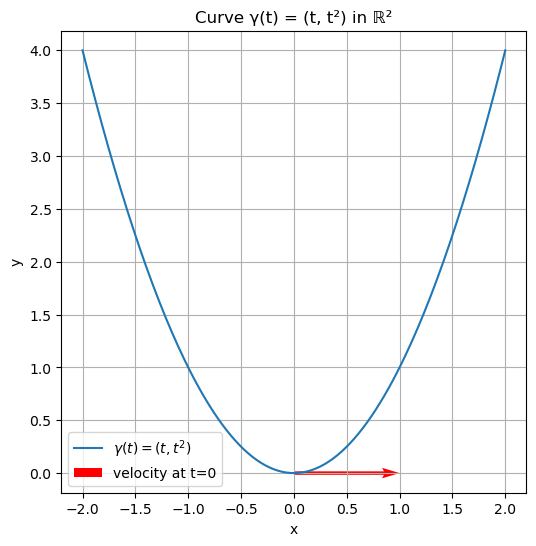

In [2]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(-2, 2, 200)
x = t
y = t**2

plt.figure(figsize=(6, 6))
plt.plot(x, y, label=r'$\gamma(t) = (t, t^2)$')
plt.quiver(0, 0, 1, 0, angles='xy', scale_units='xy', scale=1, color='r', label='velocity at t=0')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title('Curve γ(t) = (t, t²) in ℝ²')
plt.show()


In [3]:
import jax
import jax.numpy as jnp

# ----------------------------
# Helpers / sphere primitives
# ----------------------------
def normalize(x):
    return x / jnp.linalg.norm(x)

# Great-circle path g: R -> S^2 (north to south along x–z plane)
# t in [0, 1] goes from (0,0,1) to (0,0,-1). Extend as you like.
def g(t):
    theta = jnp.pi * t
    x = jnp.sin(theta)
    y = 0.0
    z = jnp.cos(theta)
    return jnp.array([x, y, z])  # already unit length

# Tangent (velocity) on the sphere via automatic differentiation
dg_dt = jax.jacfwd(g)  # returns 3-vector; automatically tangent for this g

# Optional: robust projection onto tangent plane at g(t) (safety against numerical drift)
def tangent_at(t):
    p = g(t)
    v = dg_dt(t)
    return v - jnp.dot(v, p) * p  # projection onto T_p S^2

# -----------------------------------
# Stereographic charts and inverses
# -----------------------------------
# Chart from NORTH pole:  φ_N : S^2 \ {N} -> R^2
def phi_N(p):
    x, y, z = p
    denom = 1.0 - z
    # Avoid division by ~0 near north pole by convention; caller chooses chart.
    return jnp.array([x/denom, y/denom])

# Inverse: R^2 -> S^2 \ {N}
def phi_N_inv(u):
    u1, u2 = u
    r2 = u1*u1 + u2*u2
    denom = r2 + 1.0
    return jnp.array([
        2.0*u1/denom,
        2.0*u2/denom,
        (r2 - 1.0)/denom
    ])

# Chart from SOUTH pole:  φ_S : S^2 \ {S} -> R^2
def phi_S(p):
    x, y, z = p
    denom = 1.0 + z
    return jnp.array([x/denom, y/denom])

# Inverse: R^2 -> S^2 \ {S}
def phi_S_inv(u):
    u1, u2 = u
    r2 = u1*u1 + u2*u2
    denom = r2 + 1.0
    return jnp.array([
        2.0*u1/denom,
        2.0*u2/denom,
        (1.0 - r2)/denom
    ])

# Transition map on the overlap (classical result):
# (u_S, v_S) = (u_N, v_N) / (u_N^2 + v_N^2)
def transition_N_to_S(uN):
    r2 = jnp.sum(uN*uN)
    return uN / r2

# -----------------------------------
# Local coordinates and velocities
# -----------------------------------
# Choose chart by hemisphere (z>0 use North, else South). Add margins if desired.
def which_chart(p):
    return jnp.where(p[2] > 0.0, 0, 1)  # 0=N, 1=S

# Local coordinates of g(t) in the selected chart
def local_coords(t):
    p = g(t)
    c = which_chart(p)
    u = jax.lax.cond(
        c == 0,
        lambda p_: phi_N(p_),
        lambda p_: phi_S(p_),
        p
    )
    return u, c

# Local velocity (coordinate time-derivative) using chain rule:
# d/dt [ φ(g(t)) ] = J_φ(g(t)) · \dot g(t)
def local_velocity(t):
    # We differentiate the composition directly to avoid writing Jacobians by hand.
    p = g(t)
    v = tangent_at(t)

    def comp_N(t_): return phi_N(g(t_))
    def comp_S(t_): return phi_S(g(t_))

    c = which_chart(p)
    du_dt = jax.lax.cond(
        c == 0,
        lambda tt: jax.jacfwd(comp_N)(tt),  # 2x1 (since comp_N: R->R^2)
        lambda tt: jax.jacfwd(comp_S)(tt),
        t
    )
    # jacfwd(comp)(t) returns shape (2,), i.e., d u_i / dt
    return du_dt, c

# -----------------------------------
# Vectorized utilities (batch over T)
# -----------------------------------
vmap_local_coords   = jax.vmap(local_coords)
vmap_local_velocity = jax.vmap(local_velocity)
vmap_g              = jax.vmap(g)
vmap_tangent        = jax.vmap(tangent_at)

# -----------------------------------
# Example usage
# -----------------------------------
if __name__ == "__main__":
    # Sample times from north (t=0) to south (t=1)
    T = jnp.linspace(0.0, 1.0, 6)

    P = vmap_g(T)              # points on S^2
    V = vmap_tangent(T)        # ambient tangent vectors in R^3
    (U, C) = vmap_local_coords(T)      # local coordinates and chart id per sample
    (Ud, C2) = vmap_local_velocity(T)  # local time-derivatives (coordinate speeds)

    # Print a small demo
    for t, p, v, u, c, ud in zip(T, P, V, U, C, Ud):
        chart = "N" if int(c)==0 else "S"
        print(f"t={float(t):.2f} | chart={chart} | p={p} | u={u} | |u'|={jnp.linalg.norm(ud):.3f}")


t=0.00 | chart=N | p=[0. 0. 1.] | u=[nan nan] | |u'|=nan
t=0.20 | chart=N | p=[0.58778524 0.         0.809017  ] | u=[3.0776837 0.       ] | |u'|=16.450
t=0.40 | chart=N | p=[0.95105654 0.         0.30901697] | u=[1.3763819 0.       ] | |u'|=4.547
t=0.60 | chart=S | p=[ 0.9510565   0.         -0.30901715] | u=[1.3763822 0.       ] | |u'|=4.547
t=0.80 | chart=S | p=[ 0.5877852   0.         -0.80901706] | u=[3.0776842 0.       ] | |u'|=16.450
t=1.00 | chart=S | p=[-8.742278e-08  0.000000e+00 -1.000000e+00] | u=[-inf  nan] | |u'|=nan


In [4]:
import jax
import jax.numpy as jnp

# =========================
# Sphere & chart primitives
# =========================
def normalize(x):
    return x / jnp.linalg.norm(x)

# S^2 charts: stereographic from North / South
def phi_N(p):
    x, y, z = p
    return jnp.array([x / (1.0 - z), y / (1.0 - z)])

def phi_N_inv(u):
    u1, u2 = u
    r2 = u1*u1 + u2*u2
    d = r2 + 1.0
    return jnp.array([2.0*u1/d, 2.0*u2/d, (r2 - 1.0)/d])

def phi_S(p):
    x, y, z = p
    return jnp.array([x / (1.0 + z), y / (1.0 + z)])

def phi_S_inv(u):
    u1, u2 = u
    r2 = u1*u1 + u2*u2
    d = r2 + 1.0
    return jnp.array([2.0*u1/d, 2.0*u2/d, (1.0 - r2)/d])

def which_chart(p):
    # Use North chart when z>0, South chart otherwise
    return jnp.where(p[2] > 0.0, 0, 1)  # 0=N, 1=S

# =========================
# Geometric “go-to-target” control on S^2
# =========================
north = jnp.array([0.0, 0.0, 1.0])
south = jnp.array([0.0, 0.0, -1.0])

def tangent_project(v, x):
    # Project v onto tangent space T_x S^2
    return v - jnp.dot(v, x) * x

def u_field(x, k=1.5):
    # Geodesic direction toward target (tangent projection of south at x)
    v = south - jnp.dot(south, x) * x      # already tangent
    return k * v

# Continuous-time dynamics on S^2:  xdot = u_tan(x)
def f_dyn(x, k=1.5):
    return tangent_project(u_field(x, k), x)

# =========================
# RK4 integrator on S^2 (renormalize to keep |x|=1)
# =========================
def rk4_step(x, dt, k=1.5):
    k1 = f_dyn(x, k)
    k2 = f_dyn(normalize(x + 0.5*dt*k1), k)
    k3 = f_dyn(normalize(x + 0.5*dt*k2), k)
    k4 = f_dyn(normalize(x + dt*k3), k)
    x_next = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return normalize(x_next)

# =========================
# Local coordinates & local coordinate speeds
# =========================
def local_coords(p):
    c = which_chart(p)
    u = jax.lax.cond(c == 0, lambda pp: phi_N(pp), lambda pp: phi_S(pp), p)
    return u, c

def local_speed(p, xdot):
    # d/dt [φ(p)] = J_φ(p) ⋅ xdot, computed via AD on composition φ∘(id)
    def comp_N(y): return phi_N(y)
    def comp_S(y): return phi_S(y)
    c = which_chart(p)
    J = jax.lax.cond(
        c == 0,
        lambda yy: jax.jacrev(comp_N)(yy),
        lambda yy: jax.jacrev(comp_S)(yy),
        p
    )  # shape (2,3)
    return J @ xdot, c  # 2-vector local coordinate velocity, chart id

# =========================
# Progress parameter t in [0,1] (north→south)
# =========================
def progress_t(x):
    # Angle from north: θ = arccos(north·x), map θ∈[0,π] -> t = θ/π
    cos_th = jnp.clip(jnp.dot(north, x), -1.0, 1.0)
    theta = jnp.arccos(cos_th)
    return theta / jnp.pi

# =========================
# Simulation loop
# =========================
def simulate_to_south(dt=0.02, horizon=8.0, k=1.5, eps=1e-5):
    steps = int(jnp.ceil(horizon / dt))
    x = north
    traj = []
    for i in range(steps):
        t_prog = progress_t(x)
        xd = f_dyn(x, k)
        u, chart_id = local_coords(x)
        u_dot, chart_id2 = local_speed(x, xd)
        traj.append((i*dt, x, xd, u, chart_id, u_dot, t_prog))
        if 1.0 - t_prog < 1e-3 and jnp.linalg.norm(x - south) < eps:
            break
        x = rk4_step(x, dt, k)
    return traj

# =========================
# Demo
# =========================
if __name__ == "__main__":
    traj = simulate_to_south(dt=0.02, horizon=8.0, k=1.5)
    for (t, x, xd, u, chart_id, u_dot, tprog) in traj[::max(1, len(traj)//8)]:
        chart = "N" if int(chart_id)==0 else "S"
        print(f"t={t:5.2f} | chart={chart} | x={x} | |xdot|={jnp.linalg.norm(xd):.3f} "
              f"| u={u} | |u'|={jnp.linalg.norm(u_dot):.3f} | progress t≈{float(tprog):.3f}")
    # Final state
    tf, xf, *_ = traj[-1]
    print(f"\nReached: t={tf:.2f}, x≈{xf}, dot(north,x)={float(jnp.dot(north, xf)):.6f}")


t= 0.00 | chart=N | x=[0. 0. 1.] | |xdot|=0.000 | u=[nan nan] | |u'|=nan | progress t≈0.000
t= 1.00 | chart=N | x=[0. 0. 1.] | |xdot|=0.000 | u=[nan nan] | |u'|=nan | progress t≈0.000
t= 2.00 | chart=N | x=[0. 0. 1.] | |xdot|=0.000 | u=[nan nan] | |u'|=nan | progress t≈0.000
t= 3.00 | chart=N | x=[0. 0. 1.] | |xdot|=0.000 | u=[nan nan] | |u'|=nan | progress t≈0.000
t= 4.00 | chart=N | x=[0. 0. 1.] | |xdot|=0.000 | u=[nan nan] | |u'|=nan | progress t≈0.000
t= 5.00 | chart=N | x=[0. 0. 1.] | |xdot|=0.000 | u=[nan nan] | |u'|=nan | progress t≈0.000
t= 6.00 | chart=N | x=[0. 0. 1.] | |xdot|=0.000 | u=[nan nan] | |u'|=nan | progress t≈0.000
t= 7.00 | chart=N | x=[0. 0. 1.] | |xdot|=0.000 | u=[nan nan] | |u'|=nan | progress t≈0.000

Reached: t=7.98, x≈[0. 0. 1.], dot(north,x)=1.000000
